# Interaction and Concurrency

A102462 - João Afonso Almeida Sousa

## 2x2 Binary Sudoku



### **Grover's Algorithm**

In [144]:
#!pip install pennylane


In [145]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

In [146]:
# Definimos as soluções válidas para o Sudoku binário 2x2
# As soluções são: 0110 (6) e 1001 (9) em decimal
valid_solutions = [6, 9]  

n_qubits = 4  # 4 células, cada uma representada por 1 qubit

dev = qml.device("default.qubit", wires=n_qubits)

In [147]:
def int_to_bitstring(i, n):
    return format(i, f"0{n}b")

# Oracle que marca as soluções válidas com fase -1
def oracle():
    for s in valid_solutions:
        bitstring = int_to_bitstring(s, n_qubits)
        
        # Aplica X para bits 0 (prepara o estado)
        for i, bit in enumerate(bitstring):
            if bit == "0":
                qml.PauliX(wires=i)

        # Operador controlado-Z (marca a solução)
        controlled_z = qml.ctrl(qml.PauliZ, control=range(n_qubits - 1))
        controlled_z(wires=n_qubits - 1)

        # Desfaz X para bits 0
        for i, bit in enumerate(bitstring):
            if bit == "0":
                qml.PauliX(wires=i)


In [148]:
def diffuser():
    for i in range(n_qubits):
        qml.Hadamard(wires=i)
        qml.PauliX(wires=i)
    controlled_z = qml.ctrl(qml.PauliZ, control=range(n_qubits - 1))
    controlled_z(wires=n_qubits - 1)
    for i in range(n_qubits):
        qml.PauliX(wires=i)
        qml.Hadamard(wires=i)


In [149]:
# Circuito de Grover completo com 1 iteração
@qml.qnode(dev)
def grover_circuit():
    # Inicializa em superposição uniforme
    for i in range(n_qubits):
        qml.Hadamard(wires=i)
    
    # Aplica oracle e diffuser
    oracle()
    diffuser()
    
    return qml.probs(wires=range(n_qubits))

In [150]:
probs = grover_circuit()
for i, p in enumerate(probs):
    if p > 1e-3:
        print(f"{int_to_bitstring(i, n_qubits)} (decimal {i}) -> {p:.4f}")

0000 (decimal 0) -> 0.0156
0001 (decimal 1) -> 0.0156
0010 (decimal 2) -> 0.0156
0011 (decimal 3) -> 0.0156
0100 (decimal 4) -> 0.0156
0101 (decimal 5) -> 0.0156
0110 (decimal 6) -> 0.3906
0111 (decimal 7) -> 0.0156
1000 (decimal 8) -> 0.0156
1001 (decimal 9) -> 0.3906
1010 (decimal 10) -> 0.0156
1011 (decimal 11) -> 0.0156
1100 (decimal 12) -> 0.0156
1101 (decimal 13) -> 0.0156
1110 (decimal 14) -> 0.0156
1111 (decimal 15) -> 0.0156


In [151]:
# Criar um dispositivo para desenho
draw_dev = qml.device("default.qubit", wires=n_qubits)

# Criar o QNode para desenho
draw_qnode = qml.QNode(grover_circuit, draw_dev)

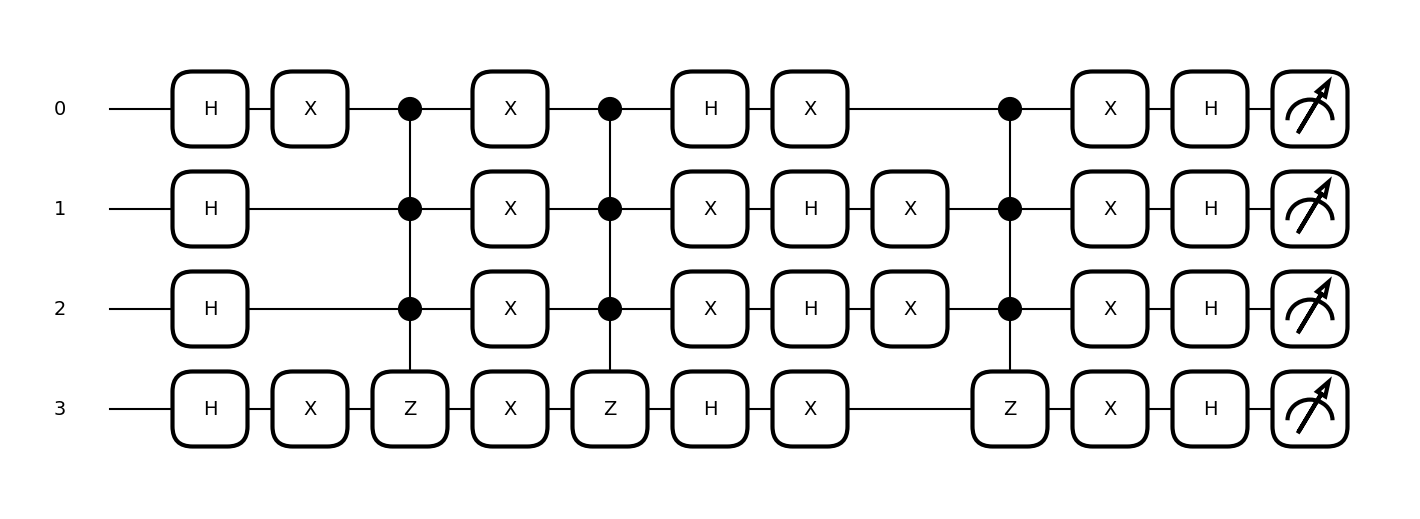

In [152]:
fig, ax = qml.draw_mpl(draw_qnode)()
plt.show()

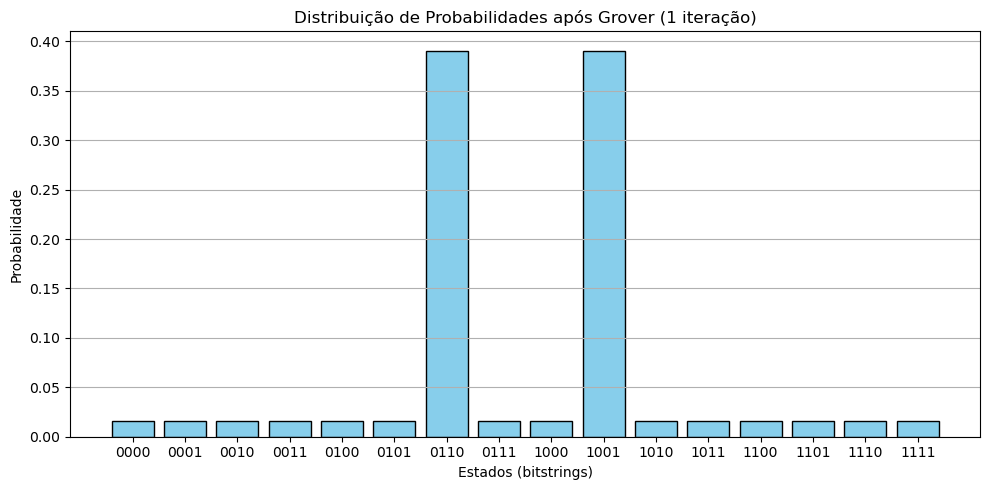

In [153]:
bitstrings = [int_to_bitstring(i, n_qubits) for i in range(2**n_qubits)]

plt.figure(figsize=(10, 5))
plt.bar(bitstrings, probs, color="skyblue", edgecolor="black")
plt.xlabel("Estados (bitstrings)")
plt.ylabel("Probabilidade")
plt.title("Distribuição de Probabilidades após Grover (1 iteração)")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

### **Assess the algorithm's efficiency and complexity**


O algoritmo de Grover é um dos algoritmos quânticos mais importantes, oferecendo uma vantagem quadrática em problemas de busca não estruturada.

No caso do sudoku binário 2x2:
- **Espaço de busca clássico:**
Existem $N = 2^4 = 16$ estados possíveis (4 células binárias). Um algoritmo clássico precisaria de verificar, **no pior caso**, até **16** estados.

- **Grover quântico:**
Com $M = 2$ soluções válidas, o número ótimo de iterações é 
$$
r \approx \left\lfloor \frac{\pi}{4} \sqrt{\frac{N}{M}} \right\rfloor
= \left\lfloor \frac{\pi}{4} \sqrt{8} \right\rfloor \approx 2
$$
 
Na prática, com apenas **1 iteração**, o algoritmo já amplifica significativamente as probabilidades dos estados solução *(como visto no gráfico)*.

##### Comparação direta

- **Clássico**: tempo de execução $O(N)$ = $O(16)$ no pior caso (verifica todas as possibilidades).
- **Grover (quântico)**: tempo de execução $O\left(\sqrt{\frac{N}{M}}\right)$ = $O\left(\sqrt{8}\right) \approx 3$, o que representa uma **vantagem quadrática**.


#### Limitações

- Apesar da melhoria teórica, a vantagem só é significativa para instâncias maiores. Para sudoku 2x2, o problema é trivial também para um algoritmo clássico.

- O algoritmo assume um oráculo eficiente (que marca as soluções). A construção deste oráculo pode ser complexa em problemas reais ou maiores.

- Com mais soluções $M$, o número ótimo de iterações muda. Se forem aplicadas demasiadas iterações, a probabilidade começa a **decrescer** novamente.

#### Conclusão

O **algoritmo de Grover** mostra-se **eficiente** mesmo em problemas pequenos como o sudoku binário 2x2, mas a sua verdadeira força está em problemas com um espaço de busca muito maior, onde a vantagem quadrática é mais significativa.

### **Propose a generalization for 3x3 sudoku and discuss potential limitations and resources required.**

Para um Sudoku 3x3 com valores 0, 1 e 2, as restrições são:

- Cada linha deve conter todos os três valores (0, 1, 2), sem repetições  
- Cada coluna deve conter todos os três valores, sem repetições  
- Cada uma das três subgrades 3x1 deve conter todos os três valores, sem repetições  

Isso requer 9 células, cada uma podendo conter 3 estados possíveis (0, 1 ou 2).

#### **Generalização**

**Representação Quântica**

Seriam necessários:

- 9 qutrits (sistemas quânticos de 3 níveis) ou alternativamente 18 qubits (2 qubits por célula, representando até 4 estados, com 1 estado não utilizado)
- O oráculo teria que verificar todas as restrições de linhas, colunas e subgrades
- O operador de difusão (Grover) amplificaria os estados solução


**Design do Oráculo**

O oráculo deve implementar as seguintes verificações:

- Para cada linha: garantir que as 3 células têm valores distintos
- Para cada coluna: garantir que as 3 células têm valores distintos
- Para cada subgrade 3x1: garantir que as 3 células têm valores distintos

Isto exigiria circuitos quânticos complexos para comparação de valores e verificação de restrições.


#### **Desafios e Limitações**

**Requisitos de Qubits**

- Usar qubits em vez de qutrits exige quase o dobro dos qubits (18 em vez de 9)
- Computadores quânticos atuais têm menos de 100 qubits utilizáveis

**Complexidade de Portas**

- O oráculo exigiria várias portas multi-controladas
- Cada verificação de restrição exigiria múltiplas operações quânticas
- A profundidade do circuito cresce substancialmente

**Taxas de Erro**

- Circuitos longos aumentam a probabilidade de erro
- Dispositivos NISQ atuais têm taxas de erro elevadas que inviabilizam estas execuções

**Espaço de Soluções**

- Para 3x3 com valores 0–2, existem \(3^9 = 19\,683\) atribuições possíveis
- Apenas 12 soluções válidas (ignorando simetrias)
- Espaço de busca muito maior comparado ao caso 2x2 binário

**Amplificação de Amplitude**

- Mais iterações de Grover seriam necessárias para amplificar as soluções
- Cada iteração executa todo o circuito do oráculo e difusão

#### **Recursos Necessários**


Para um Sudoku 3x3 com qubits:

- São necessários 18 qubits (2 por célula)
- A profundidade do circuito do oráculo provavelmente excede 100 portas
- Seriam necessárias centenas de iterações de Grover
- A profundidade total do circuito poderia facilmente ultrapassar 10.000 portas

O hardware quântico atual não consegue executar circuitos tão grandes de forma fiável. Mesmo com correção de erros, seria necessário:

- Milhares de qubits físicos (para correção de erro)
- Taxas de erro extremamente baixas
- Técnicas avançadas de compilação e otimização

#### **Conclusão**

Embora seja teoricamente possível, implementar o algoritmo de Grover para um Sudoku 3x3 em hardware quântico atual é impraticável, devido a:

- Número limitado de qubits disponíveis
- Altas taxas de erro
- Exigências excessivas na profundidade do circuito
- Complexidade na construção de oráculos quânticos

O caso 2x2 binário é um bom exemplo didático dos princípios, mas escalar para problemas maiores requer:

- Correção de erro quântico mais avançada
- Aumento do número de qubits e conectividade
- Melhorias nas fidelidades de portas
- Técnicas de compilação otimizadas para problemas de satisfação de restrições

Isto evidencia as limitações atuais da computação quântica para problemas práticos, apesar das vantagens teóricas.
